# Capstone Project: Battle of the Neighbourhoods


In [0]:
!pip install lxml
!pip install pandasql
!pip install geopy
import random # library for random number generation
from pandasql import sqldf
import numpy as np 
import pandas as pd 
import folium
import json # library to handle json files
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim 
import requests
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

print('Libraries imported.')

     |████████████████████████████████| 5.8MB 28.8MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql
     |████████████████████████████████| 102kB 12.3MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
Libraries imported.


# Manhattan and Toronto
The property management company has already had success with the Manhattan neighbourhood of Marble Hill. To best help the company decide which Toronto neighbourhood they should choose, I will be clustering the Toronto neighbourhoods and exploring their venues, in comparison to the Manhattan neighbourhood of Marble Hill. The company has decided to only consider neighbourhoods within boroughs that include the name 'Toronto'.

For a look at Marble Hill in depth, as well as further exploratory data analysis for Manhattan, see the notebook titled 'Manhattan Data Analysis' on Github.

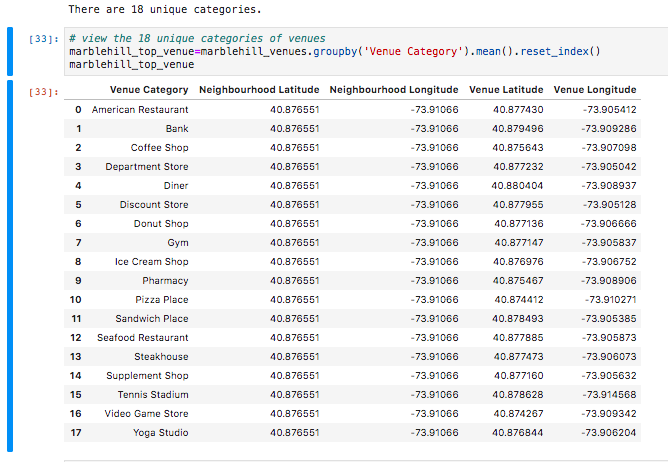

In [0]:
# importing image of Marble Hill venues from the Manhattan Data Analysis notebook
from IPython.display import Image
Image(filename="python_marblehill.png", width=400, height=400)

There are 18 categories of venues in Marble Hill, Manhattan. We want to find a neighbourhood in Toronto that's comparable in terms of venue variety.

Let's start by loading the Toronto data:

In [0]:
url ='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dataset_list = pd.read_html(url, header=0)

In [0]:
# Get the first table in the list of dataframes. Assign a name to it. 
postal_codes_df = dataset_list[0]

In [0]:
# View the first 10 records of the data frame before cleaning
postal_codes_df.head(10)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


There are a lot of 'Not assigned' values, which we need to get rid of in order to properly assess the data.

In [0]:
# Let's check the data frame's dimensions before we clean the data
postal_codes_df.shape

(288, 3)

Now let's clean up the data!

In [0]:
# remove 'Not assigned' values from the Borough column
postal_codes_df = postal_codes_df.query("Borough != 'Not assigned'")

In [0]:
# view the data
postal_codes_df.head(20)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


In [0]:
# group the data by Postcode and then by Borough
postal_codes_df = postal_codes_df.groupby(['Postcode','Borough'], as_index = False, sort = False)
postal_codes_df = postal_codes_df.agg(', '.join)
postal_codes_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Not assigned


Oops! There is still a 'Not assigned' in the Neighbourhood column. 

In [0]:
# remove 'Not assigned' values from Neighbourhood column
postal_codes_df.query("Neighbourhood == 'Not assigned'")

,Postcode,Borough,Neighbourhood
4,M7A,Queen's Park,Not assigned


There's only one row where the Neighbourhood is 'Not assigned' - let's replace that value with the borough name:

In [0]:
postal_codes_df.loc[postal_codes_df.Neighbourhood == 'Not assigned','Neighbourhood'] = "Queen's Park"

In [0]:
postal_codes_df.shape

(103, 3)

Let's view the coordinates of the Toronto postal codes:

In [0]:
# To use a dataset from a raw github file
url = 'https://raw.githubusercontent.com/jsphyg/test_data/master/Geospatial_Coordinates.csv'

geocode_df=pd.read_csv(url)
geocode_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now let's join this new dataframe with our previous Boroughs and Neighbourhoods dataframe:

In [0]:
# using SQL in python makes joining dataframes cleaner and simpler
query = """
    SELECT 
        p.*, Latitude, Longitude
    FROM postal_codes_df as p
    INNER JOIN geocode_df as g ON p.PostCode = g.'Postal Code'
"""
postal_codes_df = sqldf(query)
postal_codes_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [0]:
postal_codes_df.shape

(103, 5)

In [0]:
# let's map the current dataframe
postal_map = folium.Map(location=[43.753259, -79.329656], zoom_start = 11)

for i in range(0,len(postal_codes_df)):
    folium.Marker([postal_codes_df.iloc[i]['Latitude'], postal_codes_df.iloc[i]['Longitude']]).add_to(postal_map)
    
postal_map

The property management company wants to choose a neighbourhood within a Borough that includes the name 'Toronto', as they believe these boroughs are trending with young professionals. So let's focus only on Boroughs where Toronto is included in the name:

In [0]:
query = """
    SELECT 
        *
    FROM postal_codes_df 
    WHERE Borough like '%Toronto%'
"""
Toronto_df = sqldf(query)
Toronto_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


Now let's use Foursquare API to explore the venues in these neighbourhoods:

In [0]:
CLIENT_ID = 'M3IDXSOOZWUIIRWRCND3AXKSZYRJWJJEMRKEBTKMOIVVBXA2' # your Foursquare ID
CLIENT_SECRET = 'G0FJEHYLIDPREQ2QOIM2MANQC2KGR25PTNPCM3TGVZVNG4NK' # your Foursquare Secret
VERSION = '20180604'

In [0]:
# remove duplicate Boroughs from dataframe
Toronto_subset = Toronto_df.drop_duplicates(['Borough'], keep = 'last')
Toronto_subset

,Postcode,Borough,Neighbourhood,Latitude,Longitude
27,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450
30,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049
36,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
37,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558


Notice East Toronto has a strange Neighbourhood name, so let's drop that borough:

In [0]:

query = """
    SELECT 
        *
    FROM Toronto_df 
    WHERE Borough not like '%East Toronto%'
"""
Toronto_df = sqldf(query)
Toronto_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


In [0]:
# remove duplicate Boroughs from dataframe
Toronto_subset = Toronto_df.drop_duplicates(['Borough'], keep = 'last')
Toronto_subset

,Postcode,Borough,Neighbourhood,Latitude,Longitude
23,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450
26,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049
32,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160


I want to get the coordinates for these Toronto-named Boroughs, so that we can map them later on and take a closer look:

In [0]:
# explore neighbourhoods within these three boroughs
neighbourhood_latitude = Toronto_subset['Latitude'].iloc[0] 
neighbourhood_longitude = Toronto_subset['Longitude'].iloc[0] 
LIMIT = 100  # limit 100 rows 
radius = 1000 # this is in meters. 5 miles equals 8046.72 meters

neighbourhood_latitude

43.6515706

In [0]:
neighbourhood_longitude

-79.4844499

In [0]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

url

'https://api.foursquare.com/v2/venues/explore?&client_id=M3IDXSOOZWUIIRWRCND3AXKSZYRJWJJEMRKEBTKMOIVVBXA2&client_secret=G0FJEHYLIDPREQ2QOIM2MANQC2KGR25PTNPCM3TGVZVNG4NK&v=20180604&ll=43.6515706,-79.4844499&radius=1000&limit=100'

Now that we've got our Foursquare url for these boroughs, let's look at popular venues:

In [0]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,...,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.venuePage.id,venue.location.neighborhood
0,e-0-4e5ffdf962e13e3bcd932a0a-0,0,"[{'summary': 'This spot is popular', 'type': '...",4e5ffdf962e13e3bcd932a0a,The Good Fork,2432 Bloor St. W,Jane,43.649565,-79.484023,"[{'label': 'display', 'lat': 43.64956534036813...",...,CA,Toronto,ON,Canada,"[2432 Bloor St. W (Jane), Toronto ON M6S 1P9, ...","[{'id': '4d4b7105d754a06374d81259', 'name': 'F...",0,[],32831185,NaN
1,e-0-4b15aef7f964a52074b223e3-1,0,"[{'summary': 'This spot is popular', 'type': '...",4b15aef7f964a52074b223e3,Asa Sushi,18 Jane St.,Bloor,43.649902,-79.484611,"[{'label': 'display', 'lat': 43.64990164450559...",...,CA,Toronto,ON,Canada,"[18 Jane St. (Bloor), Toronto ON, Canada]","[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",0,[],NaN,NaN
2,e-0-51f2a052498e3c69bf38ee85-2,0,"[{'summary': 'This spot is popular', 'type': '...",51f2a052498e3c69bf38ee85,The One That Got Away,2392 Bloor St W,NaN,43.649842,-79.482615,"[{'label': 'display', 'lat': 43.64984188412754...",...,CA,Toronto,ON,Canada,"[2392 Bloor St W, Toronto ON, Canada]","[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",0,[],NaN,NaN
3,e-0-4b52112bf964a520416527e3-3,0,"[{'summary': 'This spot is popular', 'type': '...",4b52112bf964a520416527e3,DAVIDsTEA,2285 Bloor St W,NaN,43.650584,-79.478853,"[{'label': 'display', 'lat': 43.65058422430476...",...,CA,Toronto,ON,Canada,"[2285 Bloor St W, Toronto ON M6S 1P1, Canada]","[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",0,[],NaN,NaN
4,e-0-5434a336498e25b50077e07d-4,0,"[{'summary': 'This spot is popular', 'type': '...",5434a336498e25b50077e07d,Campo,244 Jane St.,Jane And Bloor,43.655191,-79.487067,"[{'label': 'display', 'lat': 43.655191, 'lng':...",...,CA,Toronto,ON,Canada,"[244 Jane St. (Jane And Bloor), Toronto ON M6S...","[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",0,[],NaN,Humberside


# What are the venue categories?

In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,The Good Fork,Food,43.649565,-79.484023
1,Asa Sushi,Sushi Restaurant,43.649902,-79.484611
2,The One That Got Away,Fish & Chips Shop,43.649842,-79.482615
3,DAVIDsTEA,Tea Room,43.650584,-79.478853
4,Campo,Italian Restaurant,43.655191,-79.487067


# Map Time
Let's view these on a map.

In [0]:
venues_map = folium.Map(location=[43.6515706, -79.4844499], zoom_start = 11)

for lat, lng, label in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['categories']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(venues_map)         

for i in range(0,len(postal_codes_df)):
    folium.Marker([postal_codes_df.iloc[i]['Latitude'], postal_codes_df.iloc[i]['Longitude']]).add_to(venues_map)
# add markers to map
for lat, lng, neighbourhood, label in zip(postal_codes_df['Latitude'], postal_codes_df['Longitude'], postal_codes_df['Borough'], postal_codes_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(venues_map) 
venues_map

If we zoom into the map where the cluster of red dots are, we can see that Etobicoke and West Toronto are the closest to the top venues. It would seem that one of the neighbourhoods here could be a prime location for a new apartment complex!

Let's cluster West Toronto neighbourhoods, since we know we need a a neighbourhood from a borough called 'Toronto':

In [0]:
# cluster neighbourhoods in the borough of West Toronto
West_Toronto_df = Toronto_df[Toronto_df['Borough'] == 'West Toronto'].reset_index(drop=True)
West_Toronto_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259
1,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750
2,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191
3,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763
4,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325


Let's get the coordinates of West Toronto:

In [0]:
address = 'West Toronto, CA'

geolocator = Nominatim(user_agent="wt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of West Toronto are {}, {}.'.format(latitude, longitude))


The geograpical coordinates of West Toronto are 43.653963, -79.387207.


In [0]:
# create map of West Toronto using latitude and longitude values
map_west_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(West_Toronto_df['Latitude'], West_Toronto_df['Longitude'], West_Toronto_df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_west_toronto)  
    
map_west_toronto



The map shows a few neighbourhoods, but we need to also see the venues in more detail:

In [0]:
# define Foursquare credentials
CLIENT_ID = 'M3IDXSOOZWUIIRWRCND3AXKSZYRJWJJEMRKEBTKMOIVVBXA2'
CLIENT_SECRET = 'G0FJEHYLIDPREQ2QOIM2MANQC2KGR25PTNPCM3TGVZVNG4N'
VERSION = '20180604'

In [0]:
# view the neighbourhood name
West_Toronto_df.loc[0, 'Neighbourhood']
# get the neighbourhood's latitude and longitude
neighbourhood_latitude = West_Toronto_df.loc[0, 'Latitude'] # neighbourhood latitude value
neighbourhood_longitude = West_Toronto_df.loc[0, 'Longitude'] # neighbourhood longitude value

neighbourhood_name = West_Toronto_df.loc[0, 'Neighbourhood'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))


Latitude and longitude values of Dovercourt Village, Dufferin are 43.66900510000001, -79.4422593.


We've been given the coordinates for Dovercourt Village, Dufferin. Now let's take a look at venues in that neighbourhood:

In [0]:
LIMIT = 100  # limit seems to be 100 rows anyway
radius = 500 # this is in meters.

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

url

'https://api.foursquare.com/v2/venues/explore?&client_id=M3IDXSOOZWUIIRWRCND3AXKSZYRJWJJEMRKEBTKMOIVVBXA2&client_secret=G0FJEHYLIDPREQ2QOIM2MANQC2KGR25PTNPCM3TGVZVNG4N&v=20180604&ll=43.66900510000001,-79.4422593&radius=500&limit=100'

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID'          
                            ]
    
    return(nearby_venues)

In [0]:
mask = West_Toronto_df['Neighbourhood'] == 'Dovercourt Village, Dufferin' #Make a boolean mask for West Toronto Borough
df = West_Toronto_df.copy() #Make a copy to leave our original DF intact
df = df[mask] #Now use the mask to eliminate entries not in West Toronto
df.reset_index(inplace = True) #Now reset the index so we can use it
df.drop('index', axis = 1, inplace = True)
df.head() #And take a look at our work so far

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259


When using Foursquare API, it's important to use your credentials each time you make a new call:

In [0]:
CLIENT_ID = 'M3IDXSOOZWUIIRWRCND3AXKSZYRJWJJEMRKEBTKMOIVVBXA2' # your Foursquare ID
CLIENT_SECRET = 'G0FJEHYLIDPREQ2QOIM2MANQC2KGR25PTNPCM3TGVZVNG4NK' # your Foursquare Secret
VERSION = '20180604'

In [0]:
# view the neighbourhood name
df.loc[0, 'Neighbourhood']
# get the neighbourhood's latitude and longitude
neighbourhood_latitude = df.loc[0, 'Latitude'] # neighbourhood latitude value
neighbourhood_longitude = df.loc[0, 'Longitude'] # neighbourhood longitude value

neighbourhood_name = df.loc[0, 'Neighbourhood'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Dovercourt Village, Dufferin are 43.66900510000001, -79.4422593.


Dovercourt Village, Dufferin is located in West Toronto, where we previously saw all of those venues clustered on the map. Let's look at the specific venues and categories here:

In [0]:
radius = 500
LIMIT = 20

dovercourt_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Dovercourt Village, Dufferin


In [0]:
dovercourt_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,"Dovercourt Village, Dufferin",43.669005,-79.442259,The Greater Good Bar,43.669409,-79.439267,Bar,5753753b498eeb535c53aed5
1,"Dovercourt Village, Dufferin",43.669005,-79.442259,Parallel,43.669516,-79.438728,Middle Eastern Restaurant,5a5659ab17556229a036b74a
2,"Dovercourt Village, Dufferin",43.669005,-79.442259,Happy Bakery & Pastries,43.667050,-79.441791,Bakery,4bdf2e330ee3a593143c33b0
3,"Dovercourt Village, Dufferin",43.669005,-79.442259,Planet Fitness Toronto Galleria,43.667588,-79.442574,Gym / Fitness Center,54468744498ed0b9299a6abe
4,"Dovercourt Village, Dufferin",43.669005,-79.442259,FreshCo,43.667918,-79.440754,Supermarket,4c717617d97fa143dcf4f8ca
5,"Dovercourt Village, Dufferin",43.669005,-79.442259,Blood Brothers Brewing,43.669944,-79.436533,Brewery,568333d5498e400ae0f1a732
6,"Dovercourt Village, Dufferin",43.669005,-79.442259,Nova Era Bakery,43.669886,-79.437582,Bakery,4c3362df452620a1e87d230f
7,"Dovercourt Village, Dufferin",43.669005,-79.442259,Rehearsal Factory,43.668877,-79.443603,Music Venue,4b52325ef964a5201b6f27e3
8,"Dovercourt Village, Dufferin",43.669005,-79.442259,The Sovereign,43.673116,-79.440265,Café,4fc67d32e4b0b0e32cca5b24
9,"Dovercourt Village, Dufferin",43.669005,-79.442259,Rexall,43.668020,-79.440876,Pharmacy,4bb4b34b8786ef3bc7866533


In [0]:
# checking the size of the dataframe
print(dovercourt_venues.shape)
dovercourt_venues.head()

(14, 8)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,"Dovercourt Village, Dufferin",43.669005,-79.442259,The Greater Good Bar,43.669409,-79.439267,Bar,5753753b498eeb535c53aed5
1,"Dovercourt Village, Dufferin",43.669005,-79.442259,Parallel,43.669516,-79.438728,Middle Eastern Restaurant,5a5659ab17556229a036b74a
2,"Dovercourt Village, Dufferin",43.669005,-79.442259,Happy Bakery & Pastries,43.667050,-79.441791,Bakery,4bdf2e330ee3a593143c33b0
3,"Dovercourt Village, Dufferin",43.669005,-79.442259,Planet Fitness Toronto Galleria,43.667588,-79.442574,Gym / Fitness Center,54468744498ed0b9299a6abe
4,"Dovercourt Village, Dufferin",43.669005,-79.442259,FreshCo,43.667918,-79.440754,Supermarket,4c717617d97fa143dcf4f8ca


In [0]:
print('There are {} unique categories.'.format(len(dovercourt_venues['Venue Category'].unique())))

There are 11 unique categories.


Compared to Marble Hill (who has 18 different categories of venues), Dovercourt Village only has 11. How similar are the categories, though?

In [0]:
# view top venues in Dovercourt Village, Dufferin
dovercourt_top_venue=dovercourt_venues.groupby('Venue Category').mean().reset_index()
dovercourt_top_venue

,Venue Category,Neighbourhood Latitude,Neighbourhood Longitude,Venue Latitude,Venue Longitude
0,Bakery,43.669005,-79.442259,43.668468,-79.439687
1,Bank,43.669005,-79.442259,43.667934,-79.441698
2,Bar,43.669005,-79.442259,43.669409,-79.439267
3,Brewery,43.669005,-79.442259,43.669944,-79.436533
4,Café,43.669005,-79.442259,43.673116,-79.440265
5,Gym / Fitness Center,43.669005,-79.442259,43.667588,-79.442574
6,Middle Eastern Restaurant,43.669005,-79.442259,43.669516,-79.438728
7,Music Venue,43.669005,-79.442259,43.668877,-79.443603
8,Park,43.669005,-79.442259,43.666933,-79.439449
9,Pharmacy,43.669005,-79.442259,43.667383,-79.444161


Let's compare this to our Marble Hill data:

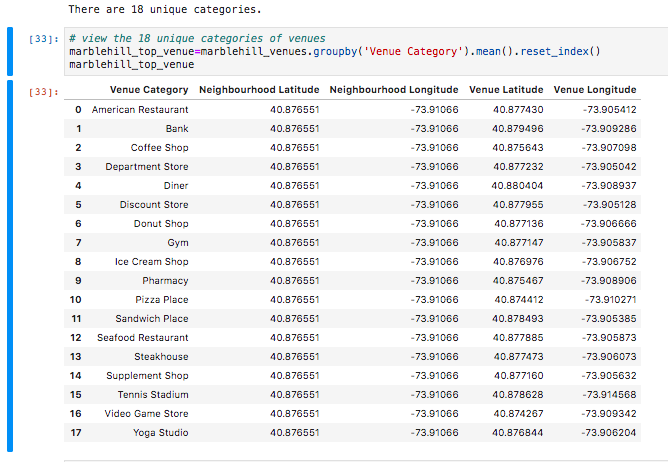

In [0]:
# importing image of Marble Hill venues from the Manhattan Data Analysis notebook
from IPython.display import Image
Image(filename="python_marblehill.png", width=400, height=400)

# Concluding Thoughts 

If we look at each neighbourhood and the corresponding venues, we can see that each neighbourhood does have a decent variety of local amenities. One might presume that the company could still build in Dovercourt Village, Dufferin and be successful. However, considering the company must pay for 60% of the overall costs of building a new property, not to mention planning fees, building regulation fees, and the additional expenses that come with building a property in another country, it's a huge risk. I would therefore recommend that the company explore other neighbourhoods, and other cities, with comparable enviornments to Marble Hill before taking such an investment risk.
 

If the company felt inclined to consider Dovercourt Village, Dufferin further, then I would suggest an analysis of Canadian culture and how it compares to Manhattan culture. Though both Toronto and Manhattan are well-to-do areas with predominantly wealthy inhabitants, cultural differences could help determine how suitable Dovercourt Village, Dufferin would be for building a new apartment complex. 

See the blog post for further in-depth analysis of the data and conclusion.

# Thank you for checking out my project!
Happy coding!